# Measure Fidelity of (random) quantum circuit

In [28]:
# create mirrored circuits
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from qiskit.providers.fake_provider import FakeManilaV2

from qiskit import execute
from qiskit import Aer

from qiskit.visualization import plot_histogram

In [29]:
def reverse_and_compose(qc):
    circ_qc = QuantumCircuit(qc.num_qubits, qc.num_qubits)
    circ_qc = QuantumCircuit(num_qubits, num_qubits)
    circ_qc.compose(qc, inplace=True)
    circ_qc.barrier()
    circ_qc.compose(qc.inverse(), inplace=True)
    for qubit in range(qc.num_qubits):
        circ_qc.measure(qubit, qubit)
    
    return circ_qc

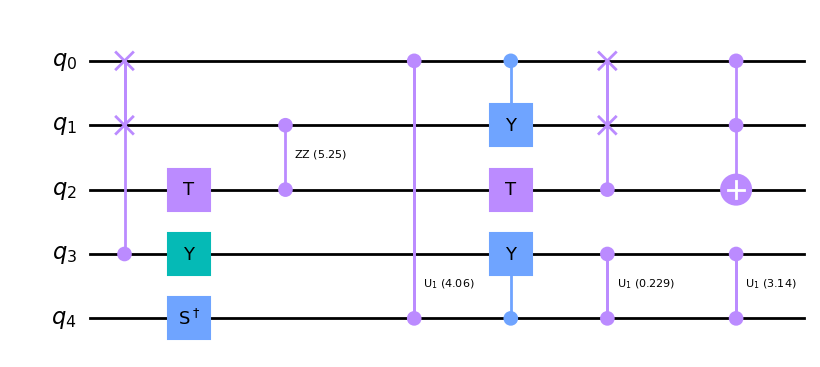

In [30]:
# create dummy ciruit with num_qubits and num_depth

num_qubits = 5
num_depth = 5

#test circuit
circ1 = random_circuit(num_qubits, num_depth, measure=False)
circ1.draw('mpl')

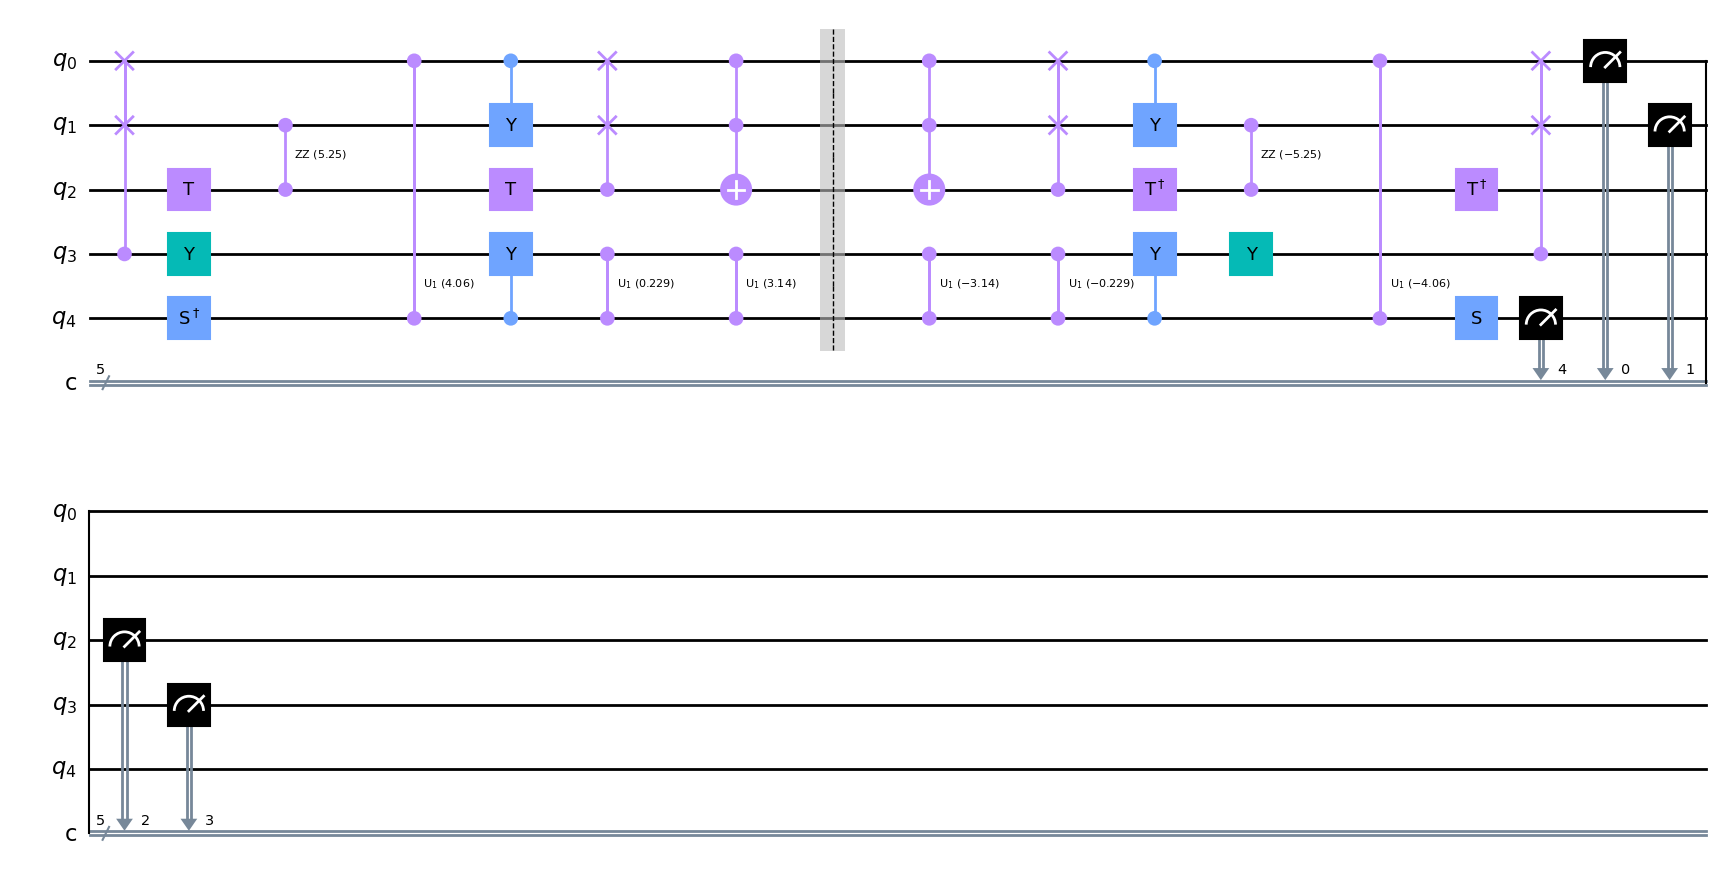

In [31]:
# now insert barrier and reverse -> result, when executing shall ideally be |0...0>
circ1_full = reverse_and_compose(circ1)
circ1_full.draw('mpl')

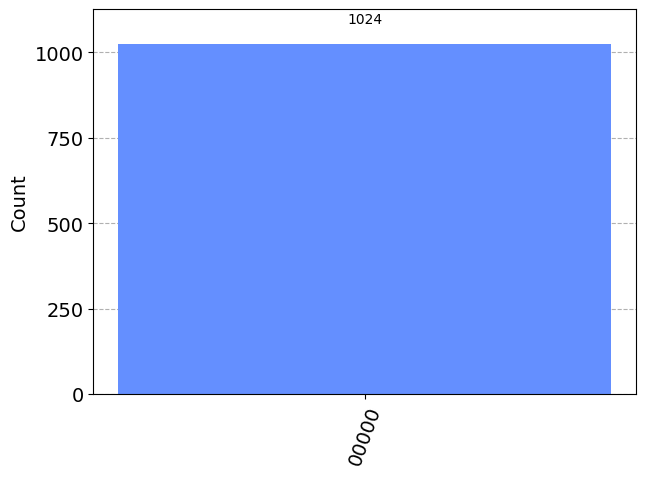

In [32]:
# execute circuit and measure outcome close to |0...0>
backend = Aer.get_backend('qasm_simulator')

job = execute(circ1_full, backend)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

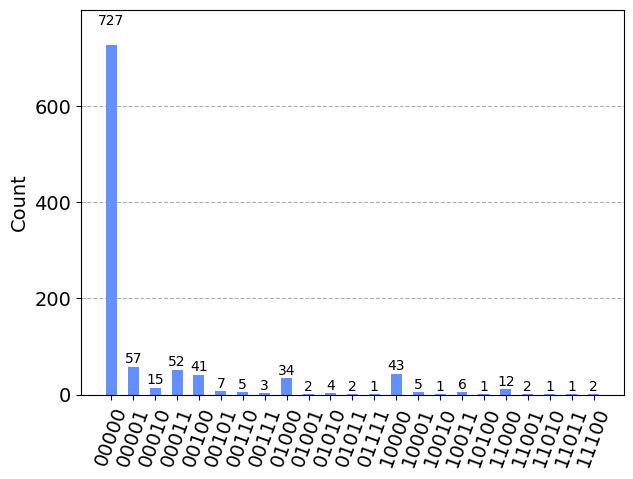

In [33]:
# now on noise hw
backend = FakeManilaV2()

job = execute(circ1_full, backend)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

# Try error mitigation by calibration

In [36]:
# try error mitigation on FakeManilaV2
# reference: https://qiskit.org/documentation/stable/0.26/tutorials/noise/3_measurement_error_mitigation.html
from qiskit.utils.mitigation import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

In [38]:
from qiskit import QuantumRegister
qr = QuantumRegister(5)
qubit_list = [0,1,2,3,4]
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

In [40]:
job = execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()

In [43]:
# The calibration matrix without noise is the identity matrix
meas_filter = meas_fitter.filter

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.893 0.19  0.026 ... 0.    0.    0.   ]
 [0.06  0.762 0.006 ... 0.    0.    0.   ]
 [0.016 0.003 0.885 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.651 0.001 0.021]
 [0.    0.    0.    ... 0.003 0.817 0.192]
 [0.    0.    0.    ... 0.011 0.046 0.663]]


In [45]:
mitigated_results = meas_filter.apply(result)
mitigated_counts = mitigated_results.get_counts(0)

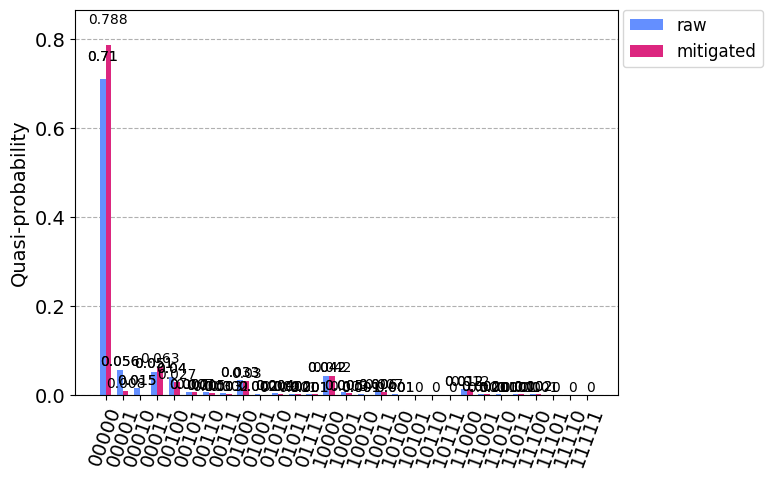

In [46]:
plot_histogram([counts, mitigated_counts], legend=['raw', 'mitigated'])

In [47]:
import qiskit.tools.jupyter

%qiskit_version_table